In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from glob import glob
import pandas as pd
%config Completer.use_jedi = False

In [2]:
exp_meta_data_dir = '../meta_data/exp'
exp_data_dir = '../processed_data/exp'
sim_data_dir = '../processed_data/sim'

In [3]:
fig_dir = 'Figures/Supplementary_figures'

In [4]:
# for plotting
plt.rcParams.update({'font.size': 20})

# Orientation tuning and direction selectivity

In [5]:
cell_names = ['e23Cux2',
 'e4Nr5a1',
 'e4Rorb',
 'e4Scnn1a',
 'e4other',
 'e5Rbp4',
 'e5noRbp4',
 'e6Ntsr1',
 'i1Htr3a',
 'i23Htr3a',
 'i23Pvalb',
 'i23Sst',
 'i4Htr3a',
 'i4Pvalb',
 'i4Sst',
 'i5Htr3a',
 'i5Pvalb',
 'i5Sst',
 'i6Htr3a',
 'i6Pvalb',
 'i6Sst']

def calculateFiringRate(gids, ts, unique_gids, gray_screen = 0, trial_dur = 1000):

    print ("Calculating Firing Rate")
    if len(gids) > 0:
        gids = gids[np.where(ts > gray_screen)[0]]

    # Can maybe use gids instead of numNrns here
    # gid_bins = np.arange(0 - 0.5, numNrns + 0.5, 1)
    gid_bins = np.arange(np.min(unique_gids) - 0.5, np.max(unique_gids) + 0.5 + 1, 1)

    hist, bins = np.histogram(gids, bins=gid_bins)

    if ~np.any(hist):
        mean_firing_rates = np.zeros(len(unique_gids))
    elif gray_screen > 0:
        mean_firing_rates = hist / (  (trial_dur - gray_screen) / 1000.)
    else:
        mean_firing_rates = hist / (trial_dur / 1000.)
    return mean_firing_rates


def calculate_Rates_DF(numNrns, path, ntrials = 10, trial_dur = 1000, mode = 'sim'):
        
    Rates_DF = pd.DataFrame(index = range(numNrns * len(path_to_ori_dirs)), columns= ['DG_angle', 'node_id', 'Avg_rate(Hz)', 'SD_rate(Hz)', 'cell_pop'])
    
    ncells_tot_count = 0
    for cell_pop_name in cell_names:
        for i, ori_path in enumerate(sorted(path_to_ori_dirs)):
            loadpath = os.path.join(ori_path, 'spikes_sorted_by_pop', 'neuronIdsPerPopulation', cell_pop_name+'.txt')
            unique_gids = np.loadtxt(loadpath, unpack=True).astype(int)
            ncells_in_pop = len(unique_gids)
            firingRatesTrials = np.zeros((ntrials, ncells_in_pop))
            for itrial in range(ntrials):
                ori = int(ori_path.split('/')[-2][3:])

                print('Cell population:', cell_pop_name, 'orientation: ', ori, 'trial nr.', itrial)

                spikes_cell_pop_filename = 'onlySpikeTimes_'+cell_pop_name+'.txt'

                loadpath = os.path.join(ori_path, 'spikes_sorted_by_pop', 'onlySpikeTimesPerPopulation', spikes_cell_pop_filename)
                ts = np.loadtxt(loadpath, unpack=True)

                mask_trial = np.logical_and(ts > itrial*trial_dur, ts < (itrial+1)*trial_dur)

                ts = ts[mask_trial]

                loadpath = os.path.join(ori_path, 'spikes_sorted_by_pop', 'spikeTimesPerPopulation', 'spikeTimes_'+cell_pop_name+'.txt')
                gids_file = open(loadpath, 'r').read().splitlines()

                gids = []
                for line in gids_file:
                    gids.append(int(line.split(' ')[-1]))
                gids = np.array(gids)
                gids = gids[mask_trial]

                firingRates = calculateFiringRate(gids, ts, unique_gids, gray_screen = 500.)

                firingRatesTrials[itrial] = np.array(firingRates)
                                
            Rates_DF.loc[i*numNrns+ncells_tot_count:i*numNrns+ncells_tot_count+ncells_in_pop-1, 'DG_angle']     = ori
            Rates_DF.loc[i*numNrns+ncells_tot_count:i*numNrns+ncells_tot_count+ncells_in_pop-1, 'node_id']      = unique_gids
            Rates_DF.loc[i*numNrns+ncells_tot_count:i*numNrns+ncells_tot_count+ncells_in_pop-1, 'Avg_rate(Hz)'] = np.mean(firingRatesTrials, axis = 0)
            Rates_DF.loc[i*numNrns+ncells_tot_count:i*numNrns+ncells_tot_count+ncells_in_pop-1, 'SD_rate(Hz)']  = np.std(firingRatesTrials, axis= 0)
            Rates_DF.loc[i*numNrns+ncells_tot_count:i*numNrns+ncells_tot_count+ncells_in_pop-1, 'cell_pop']  = cell_pop_name

        ncells_tot_count += ncells_in_pop

    Rates_DF.to_csv('Rates_DF_'+mode+'.csv', sep = ' ', index = False)


def calculate_OSI_DSI_from_DF(Rates_DF, mode = 'sim'):

    node_ids = Rates_DF['node_id']
    numNrns = len(np.unique(node_ids))
    OSI_DSI_DF = pd.DataFrame(index = range(numNrns), columns= ['node_id', 'DSI', 'OSI', 'preferred_angle', 'max_mean_rate(Hz)'])
    #ori = np.arange(0, 360, 45)
    
    #path = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims/2022/drifting_gratings/final_model'
    
    #path_to_ori_dirs = glob(os.path.join(path, '*/'))

    zz = 0
    for i, node_id in enumerate(node_ids):
        rates = np.array(Rates_DF.ix[Rates_DF['node_id'] == node_id, 'Avg_rate(Hz)'])
        angles = np.array(Rates_DF.ix[Rates_DF['node_id'] == node_id, 'DG_angle'])
        if i%2000 == 0:
            print ('cell: ', i)

        if len(rates) == 0:
            continue
        max_rate_ind = np.argmax(rates)
        #if np.size(max_rate_ind) > 1:
            #print (i, rates)
        if max(rates) > 0.0:

            # DSI = (rates[max_rate_ind] - rates[ (max_rate_ind + 4) % 8]) / (rates[max_rate_ind] + rates[ (max_rate_ind + 4) % 8])
            numerator = [rates[k] * np.exp(1j* np.deg2rad(theta)) for k, theta in enumerate(angles)]
            denominator = rates
            DSI = np.abs(np.array(numerator).sum()) / denominator.sum()

            # OSI = abs(np.sum(rates*np.exp(2j*ori)) / sum(rates))
            numerator = [rates[k] * np.exp(2*1j* np.deg2rad(theta)) for k, theta in enumerate(angles)]
            denominator = rates
            OSI = np.abs(np.array(numerator).sum()) / denominator.sum()



            pref_ang = angles[max_rate_ind]
            #print('Max rates: ', max(rates))
            #print('DSI: ', DSI, 'OSI: ', OSI, 'pref_angle: ', pref_ang)
        else:
            DSI = np.nan
            OSI = np.nan
            pref_ang = np.nan

        OSI_DSI_DF.loc[i, 'node_id'] = i
        OSI_DSI_DF.loc[i, 'DSI'] = DSI
        OSI_DSI_DF.loc[i, 'OSI'] = OSI
        OSI_DSI_DF.loc[i, 'preferred_angle'] = pref_ang
        OSI_DSI_DF.loc[i, 'max_mean_rate(Hz)'] = np.max(rates)
        OSI_DSI_DF.loc[i, 'Avg_Rate(Hz)'] = np.mean(rates)


    OSI_DSI_DF.to_csv('OSI_DSI_DF_'+mode+'.csv', sep = ' ', index = False)
    
    return OSI_DSI_DF

## Simulation with final model and drifting gratings input

### Calculate firing rates 
- Time: ~10 min

In [98]:
path_to_ori_dirs = glob(os.path.join(sim_data_dir, 'sims_supp_figs', 'drifting_gratings', 'final_model', '*/'))
numNrns = 51978
Rates_DF_sim = calculate_Rates_DF(numNrns, path = path_to_ori_dirs, ntrials=10, mode='sim')
print ("Done_Rates_DF!")

cell population: e23Cux2 orientation:  0 trial nr. 0
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 1
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 2
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 3
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 4
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 5
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 6
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 7
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 8
Calculating Firing Rate
cell population: e23Cux2 orientation:  0 trial nr. 9
Calculating Firing Rate
cell population: e23Cux2 orientation:  135 trial nr. 0
Calculating Firing Rate
cell population: e23Cux2 orientation:  135 trial nr. 1
Calculating Firing Rate
cell population: e23Cux2 orientation:  135 trial nr. 2
Calculating Firin

Calculating Firing Rate
cell population: e4Nr5a1 orientation:  180 trial nr. 8
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  180 trial nr. 9
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 0
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 1
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 2
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 3
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 4
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 5
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 6
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 7
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 8
Calculating Firing Rate
cell population: e4Nr5a1 orientation:  225 trial nr. 9
Calculating Firing Rate
cell population: e4Nr5a1 ori

KeyboardInterrupt: 

#### Load precomputed firing rates

In [6]:
loadpath = os.path.join(sim_data_dir, 'sims_supp_figs', 'drifting_gratings', \
                        'final_model', 'Rates_DF_sim.csv')
Rates_DF_sim = pd.read_csv(loadpath, sep=' ', index_col=False)

### Compute OSI and DSI
- Takes a long time (~10 h). Precomputed OSI and DSI values can be loaded below.

In [ ]:
OSI_DSI_DF_sim = calculate_OSI_DSI_from_DF(Rates_DF_sim)
print ("Done with all!")

#### Load precomputed OSI and DSI values

In [7]:
loadpath = os.path.join(sim_data_dir, 'sims_supp_figs', 'drifting_gratings', \
                        'final_model', 'OSI_DSI_DF_sim.csv')

OSI_DSI_DF_sim = pd.read_csv(loadpath, sep=' ', index_col=False)

In [8]:
pop_names = ['RS L2/3', 'FS L2/3', 'RS L4', 'FS L4', 'RS L5', 'FS L5', 'RS L6', 'FS L6']

In [9]:
pop_rate_pref_dir_sim = dict()

for pop_name in pop_names:
    pop_rate_pref_dir_sim[pop_name] = []

In [11]:
for ipop, cell_pop_name in enumerate(cell_names):
    mask_cell_pop = Rates_DF_sim.cell_pop.values == cell_pop_name
    rate_at_preferred_dir = OSI_DSI_DF_sim[mask_cell_pop]['max_mean_rate(Hz)'].values
    
    if 'e23' in cell_pop_name or 'i23Sst' in cell_pop_name or 'i23Htr3a' in cell_pop_name:
        print('L2/3', cell_pop_name)
        if len(pop_rate_pref_dir_sim['RS L2/3']) == 0:
            pop_rate_pref_dir_sim['RS L2/3'] = rate_at_preferred_dir
        else:
            pop_rate_pref_dir_sim['RS L2/3'] = np.concatenate([pop_rate_pref_dir_sim['RS L2/3'], rate_at_preferred_dir])
    if 'e4' in cell_pop_name or 'i4Sst' in cell_pop_name or 'i4Htr3a' in cell_pop_name:
        print('L4', cell_pop_name)
        if len(pop_rate_pref_dir_sim['RS L4']) == 0:
            pop_rate_pref_dir_sim['RS L4'] = rate_at_preferred_dir
        else:
            pop_rate_pref_dir_sim['RS L4'] = np.concatenate([pop_rate_pref_dir_sim['RS L4'], rate_at_preferred_dir])
    elif 'e5' in cell_pop_name or 'i5Sst' in cell_pop_name or 'i5Htr3a' in cell_pop_name:
        print('L5', cell_pop_name)
        if len(pop_rate_pref_dir_sim['RS L5']) == 0:
            pop_rate_pref_dir_sim['RS L5'] = rate_at_preferred_dir
        else:
            pop_rate_pref_dir_sim['RS L5'] = np.concatenate([pop_rate_pref_dir_sim['RS L5'], rate_at_preferred_dir])
    elif 'e6' in cell_pop_name or 'i6Sst' in cell_pop_name or 'i6Htr3a' in cell_pop_name:
        print('L6', cell_pop_name)
        if len(pop_rate_pref_dir_sim['RS L6']) == 0:
            pop_rate_pref_dir_sim['RS L6'] = rate_at_preferred_dir
        else:
            pop_rate_pref_dir_sim['RS L6'] = np.concatenate([pop_rate_pref_dir_sim['RS L6'], rate_at_preferred_dir])
    elif 'Pvalb' in cell_pop_name:
        if '23' in cell_pop_name:
            print('PV 23', cell_pop_name)
            pop_rate_pref_dir_sim['FS L2/3'] = rate_at_preferred_dir
        elif '4' in cell_pop_name:
            print('PV 4', cell_pop_name)
            pop_rate_pref_dir_sim['FS L4'] = rate_at_preferred_dir
        elif '5' in cell_pop_name:
            print('PV 5', cell_pop_name)
            pop_rate_pref_dir_sim['FS L5'] = rate_at_preferred_dir
        elif '6' in cell_pop_name:
            print('PV 6', cell_pop_name)
            pop_rate_pref_dir_sim['FS L6'] = rate_at_preferred_dir
    #else:
    #    pop_rate_pref_dir[cell_pop_name] = rate_at_preferred_dir

L2/3 e23Cux2
L4 e4Nr5a1
L4 e4Rorb
L4 e4Scnn1a
L4 e4other
L5 e5Rbp4
L5 e5noRbp4
L6 e6Ntsr1
L2/3 i23Htr3a
PV 23 i23Pvalb
L2/3 i23Sst
L4 i4Htr3a
PV 4 i4Pvalb
L4 i4Sst
L5 i5Htr3a
PV 5 i5Pvalb
L5 i5Sst
L6 i6Htr3a
PV 6 i6Pvalb
L6 i6Sst


In [12]:
pop_DSI_sim = dict()

for pop_name in pop_names:
    pop_DSI_sim[pop_name] = []

In [13]:
for ipop, cell_pop_name in enumerate(cell_names):
    mask_cell_pop = Rates_DF_sim.cell_pop.values == cell_pop_name
    DSI = OSI_DSI_DF_sim[mask_cell_pop].DSI.values
    
    mask_nan = np.isnan(DSI)
    DSI = DSI[~mask_nan]
    
    if 'e23' in cell_pop_name or 'i23Sst' in cell_pop_name or 'i23Htr3a' in cell_pop_name:
        print('L2/3', cell_pop_name)
        if len(pop_DSI_sim['RS L2/3']) == 0:
            pop_DSI_sim['RS L2/3'] = DSI
        else:
            pop_DSI_sim['RS L2/3'] = np.concatenate([pop_DSI_sim['RS L2/3'], DSI])
    if 'e4' in cell_pop_name or 'i4Sst' in cell_pop_name or 'i4Htr3a' in cell_pop_name:
        print('L4', cell_pop_name)
        if len(pop_rate_pref_dir_sim['RS L4']) == 0:
            pop_DSI_sim['RS L4'] = DSI
        else:
            pop_DSI_sim['RS L4'] = np.concatenate([pop_DSI_sim['RS L4'], DSI])
    elif 'e5' in cell_pop_name or 'i5Sst' in cell_pop_name or 'i5Htr3a' in cell_pop_name:
        print('L5', cell_pop_name)
        if len(pop_DSI_sim['RS L5']) == 0:
            pop_DSI_sim['RS L5'] = DSI
        else:
            pop_DSI_sim['RS L5'] = np.concatenate([pop_DSI_sim['RS L5'], DSI])
    elif 'e6' in cell_pop_name or 'i6Sst' in cell_pop_name or 'i6Htr3a' in cell_pop_name:
        print('L6', cell_pop_name)
        if len(pop_DSI_sim['RS L6']) == 0:
            pop_DSI_sim['RS L6'] = DSI
        else:
            pop_DSI_sim['RS L6'] = np.concatenate([pop_DSI_sim['RS L6'], DSI])
    elif 'Pvalb' in cell_pop_name:
        if '23' in cell_pop_name:
            print('PV 23', cell_pop_name)
            pop_DSI_sim['FS L2/3'] = DSI
        elif '4' in cell_pop_name:
            print('PV 4', cell_pop_name)
            pop_DSI_sim['FS L4'] = DSI
        elif '5' in cell_pop_name:
            print('PV 5', cell_pop_name)
            pop_DSI_sim['FS L5'] = DSI
        elif '6' in cell_pop_name:
            print('PV 6', cell_pop_name)
            pop_DSI_sim['FS L6'] = DSI
    #else:
    #    pop_rate_pref_dir[cell_pop_name] = rate_at_preferred_dir

L2/3 e23Cux2
L4 e4Nr5a1
L4 e4Rorb
L4 e4Scnn1a
L4 e4other
L5 e5Rbp4
L5 e5noRbp4
L6 e6Ntsr1
L2/3 i23Htr3a
PV 23 i23Pvalb
L2/3 i23Sst
L4 i4Htr3a
PV 4 i4Pvalb
L4 i4Sst
L5 i5Htr3a
PV 5 i5Pvalb
L5 i5Sst
L6 i6Htr3a
PV 6 i6Pvalb
L6 i6Sst


In [14]:
pop_OSI_sim = dict()

for pop_name in pop_names:
    pop_OSI_sim[pop_name] = []

In [17]:
for ipop, cell_pop_name in enumerate(cell_names):
    mask_cell_pop = Rates_DF_sim.cell_pop.values == cell_pop_name
    OSI = OSI_DSI_DF_sim[mask_cell_pop].OSI.values
    
    mask_nan = np.isnan(OSI)
    OSI = OSI[~mask_nan]
    
    if 'e23' in cell_pop_name or 'i23Sst' in cell_pop_name or 'i23Htr3a' in cell_pop_name:
        print('L2/3', cell_pop_name)
        if len(pop_OSI_sim['RS L2/3']) == 0:
            pop_OSI_sim['RS L2/3'] = OSI
        else:
            pop_OSI_sim['RS L2/3'] = np.concatenate([pop_OSI_sim['RS L2/3'], OSI])
    if 'e4' in cell_pop_name or 'i4Sst' in cell_pop_name or 'i4Htr3a' in cell_pop_name:
        print('L4', cell_pop_name)
        if len(pop_OSI_sim['RS L4']) == 0:
            pop_OSI_sim['RS L4'] = OSI
        else:
            pop_OSI_sim['RS L4'] = np.concatenate([pop_OSI_sim['RS L4'], OSI])
    elif 'e5' in cell_pop_name or 'i5Sst' in cell_pop_name or 'i5Htr3a' in cell_pop_name:
        print('L5', cell_pop_name)
        if len(pop_OSI_sim['RS L5']) == 0:
            pop_OSI_sim['RS L5'] = OSI
        else:
            pop_OSI_sim['RS L5'] = np.concatenate([pop_OSI_sim['RS L5'], OSI])
    elif 'e6' in cell_pop_name or 'i6Sst' in cell_pop_name or 'i6Htr3a' in cell_pop_name:
        print('L6', cell_pop_name)
        if len(pop_OSI_sim['RS L6']) == 0:
            pop_OSI_sim['RS L6'] = OSI
        else:
            pop_OSI_sim['RS L6'] = np.concatenate([pop_OSI_sim['RS L6'], OSI])
    elif 'Pvalb' in cell_pop_name:
        if '23' in cell_pop_name:
            print('PV 23', cell_pop_name)
            pop_OSI_sim['FS L2/3'] = OSI
        elif '4' in cell_pop_name:
            print('PV 4', cell_pop_name)
            pop_OSI_sim['FS L4'] = OSI
        elif '5' in cell_pop_name:
            print('PV 5', cell_pop_name)
            pop_OSI_sim['FS L5'] = OSI
        elif '6' in cell_pop_name:
            print('PV 6', cell_pop_name)
            pop_OSI_sim['FS L6'] = OSI
    #else:
    #    pop_rate_pref_dir[cell_pop_name] = rate_at_preferred_dir

L2/3 e23Cux2
L4 e4Nr5a1
L4 e4Rorb
L4 e4Scnn1a
L4 e4other
L5 e5Rbp4
L5 e5noRbp4
L6 e6Ntsr1
L2/3 i23Htr3a
PV 23 i23Pvalb
L2/3 i23Sst
L4 i4Htr3a
PV 4 i4Pvalb
L4 i4Sst
L5 i5Htr3a
PV 5 i5Pvalb
L5 i5Sst
L6 i6Htr3a
PV 6 i6Pvalb
L6 i6Sst


## Load experimental spike data

In [24]:
structure = 'V1'

exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', structure, 'drifting_gratings')
filename = 'sessions_spike_counts_drifting_gratings.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

In [25]:
loadpaths_unit_depths = sorted(glob(os.path.join(exp_meta_data_dir, 'units_cortical_depth', '*')))

In [26]:

sessions_units_depth = dict()


for file_path in loadpaths_unit_depths:
    properties = dict()
    
    session_id = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    units_depth = pd.read_csv(file_path, sep=' ')
    units_depth = units_depth.set_index('id')
    
    properties['layer'] = units_depth['cortical_layer']
    properties['depth'] = units_depth['cortical_depth']
    
    sessions_units_depth[session_id] = properties

### Load precomputed firing rates

In [27]:
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'drifting_gratings', 'Rates_DF_exp.csv')

Rates_DF_exp = pd.read_csv(loadpath, sep=' ', index_col=False)

In [28]:
Rates_DF_exp['pop_name'] = np.zeros(len(Rates_DF_exp))+np.nan

In [29]:
layers_all_units = dict()
for session_id in sessions_units_depth.keys():
    for unit_id, layer in sessions_units_depth[session_id]['layer'].items():
        layers_all_units[unit_id] = layer

In [30]:
for session_id in sessions_spike_trains_V1.keys():
    for unit_type in sessions_spike_trains_V1[session_id].keys():
        for unit_id in sessions_spike_trains_V1[session_id][unit_type].unit_id.values:
            if unit_id in layers_all_units.keys():
                print(unit_id)
                mask = Rates_DF_exp['node_id'].values == unit_id
                if unit_type == 'exc':
                    Rates_DF_exp['pop_name'][mask] = 'RS L'+str(layers_all_units[unit_id])
                elif unit_type == 'inh':
                    Rates_DF_exp['pop_name'][mask] = 'FS L'+str(layers_all_units[unit_id])

950930145
950930215
950930237
950933698
950930276
950930340
950930358
950930375
950930392
950930423
950930437
950930454
950930522
950930866
950930888
950934181
950931004
950931118
950931164
950931181
950931236
950931272
950931458
950931423
950931517
950931533
950931565
950931581
950931805
950931656
950931727
950931751
950931770
950931878
950931899
950931959
950932032
950933907
950932578
950932696
950933732
950933890
950933924
950933960
950930105
950930407
950930795
950930964
950930985
950931043
950931254
950931315
950931363
950931617
950931853
950932087
950932102
950932445
950932563
950933840
950934506
950934544
950934565
950934597
950934614
950934626
950934786
950934798
950934870
950934912
950935027
950935043
950935168
950935081
950935118
950935142
950935154
950935244
950935264
950936593
950935276
950935287
950936618
950935296
950935320
950936606
950935354
950935366
950935376
950935403
950936633
950935465
950935480
950935726
950935766
950935828
950936810
950935840
950934750
950934762


/Users/atleeskelandrimehaug/opt/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/atleeskelandrimehaug/opt/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



951893072
951893081
951894396
951893117
951893135
951894612
951893144
951893161
951893214
951894407
951893232
951893246
951894425
951893344
951893394
951893453
951893479
951893488
951893626
951893540
951893548
951893556
951893566
951893600
951893662
951893682
951893723
951893732
951893740
951893748
951894472
951893973
951894016
951894507
951894131
951894480
951894525
951894631
951893223
951893359
951893531
951893691
951893780
951893860
951893871
951893982
951894058
951894548
951795075
951795086
951795098
951795140
951795163
951795222
951795238
951795256
951795269
951795290
951795309
951795317
951795403
951797419
951795458
951795474
951795487
951795495
951795554
951795680
951795563
951795611
951795663
951795688
951795706
951795713
951795721
951797465
951795729
951795737
951795747
951795873
951795753
951795782
951795792
951795760
951795768
951795775
951795807
951795824
951795832
951795839
951795858
951795880
951795886
951795896
951795918
951797520
951797539
951797553
951795936
951795943

951091978
951091944
951091997
951091969
951092220
951092061
951092085
951092162
951092188
951092210
951093476
951092237
951093487
951092289
951092339
951092333
951092370
951092506
951092523
951092530
951093505
951092671
951092679
951093514
951093533
951092765
951092815
951092917
951092925
951093031
951093061
951093594
951093445
951093540
951093549
951093560
951091321
951091685
951091707
951091780
951091866
951092070
951092203
951092078
951092169
951092245
951092262
951092354
951092425
951092575
951092652
951092717
951092943
951093075
951093093
951102476
951102534
951102555
951102601
951102623
951102646
951102673
951102820
951102846
951102860
951102922
951102934
951102976
951103019
951103080
951103093
951103150
951103163
951103238
951103262
951103290
951103361
951103420
951103380
951103455
951105218
951105231
951103488
951103498
951103508
951103589
951103624
951103518
951103553
951103566
951103652
951103671
951103691
951103735
951103757
951103768
951103779
951103799
951103810
951103854


### Compute OSI and DSI
- Takes a long time (~10 h). Precomputed values can be loaded below.

In [31]:
OSI_DSI_DF_exp = calculate_OSI_DSI_from_DF(Rates_DF_exp, mode = 'exp')
print ("Done with all!")

/Users/atleeskelandrimehaug/opt/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/Users/atleeskelandrimehaug/opt/anaconda3/envs/gen_env/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/Users/atleeskelandrimehaug/opt/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:107: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata

cell:  0


KeyboardInterrupt: 

#### Load precomputed OSI and DSI values

In [32]:
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'drifting_gratings', 'OSI_DSI_DF_exp.csv')

OSI_DSI_DF_exp = pd.read_csv(loadpath, sep=' ', index_col=False)

In [33]:
pop_names_exp = ['RS L2', 'FS L2', 'RS L4', 'FS L4', 'RS L5', 'FS L5', 'RS L6', 'FS L6']

In [34]:
pop_DSI_exp = dict()

In [35]:
for ipop, pop_name in enumerate(pop_names_exp):
    mask_pop = Rates_DF_exp.pop_name.values == pop_name
    DSI = np.array(OSI_DSI_DF_exp[mask_pop].DSI.values, dtype = float)
    
    mask_nan = np.isnan(DSI)
    DSI = DSI[~mask_nan]
    
    if pop_name == 'RS L2':
        pop_DSI_exp[pop_name+'/3'] = DSI
    elif pop_name == 'FS L2':
        pop_DSI_exp[pop_name+'/3'] = DSI
    else:
        pop_DSI_exp[pop_name] = DSI

RS L2/3 3 2 0.5
FS L2/3 3 0 0.5
RS L4 4 1 1.0
FS L4 4 0 1.0
RS L5 5 1 1.5
FS L5 5 0 1.5
RS L6 6 1 2.0
FS L6 6 0 2.0


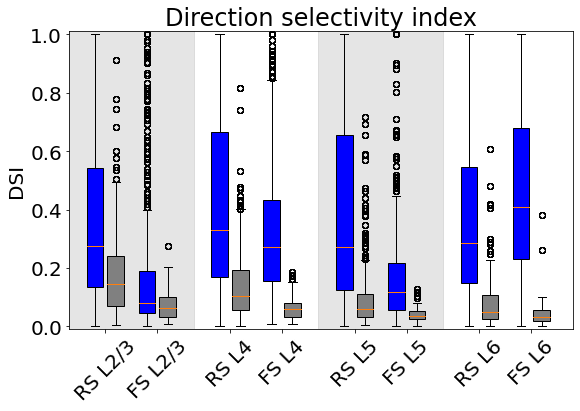

In [39]:
fig, ax = plt.subplots(figsize = (10,6))

fig.subplots_adjust(left = 0.15, right = 0.85, bottom = 0.18, top = 0.87)

layer_nrs = [1]
layer_width_dist = 0
positions = []
for ipop, pop_name in enumerate(pop_DSI_sim.keys()):
    
    layer_nr = int(pop_name[-1])
        
    if layer_nr > 1:
        if (layer_nr - layer_nrs[-1]) > 0:
            layer_width_dist += 1/2
            
        print(pop_name, layer_nr, layer_nr - layer_nrs[-1], layer_width_dist)
    layer_nrs.append(layer_nr)
    
    if 'RS' in pop_name:
        shift = -1/16
    elif 'FS' in pop_name:
        shift = 1/16
    
    positions.append(ipop/2+layer_width_dist+shift)
    
    ax.boxplot(pop_DSI_exp[pop_name], widths = [0.2], positions = [ipop/2+layer_width_dist+1/8+shift], patch_artist = True, \
                         boxprops=dict(facecolor="grey"))
    ax.boxplot(pop_DSI_sim[pop_name], widths = [0.2], positions = [ipop/2+layer_width_dist-1/8+shift], patch_artist = True, \
                         boxprops=dict(facecolor="blue"))
    
    
ax.set_xticks(positions)
ax.set_xticklabels(list(pop_DSI_sim.keys()), rotation = 45)

ax.set_ylabel('DSI')

ax.set_title('Direction selectivity index')

ax.fill_between(x = [0, 1.5], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.fill_between(x = [3, 4.5], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.fill_between(x = [16, 21], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, positions[-1]+.5])

fig_name = 'DSI_final_model_and_exp_RS_and_FS.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

In [40]:
rate_at_pref_dir_exp = dict()

In [41]:
for ipop, pop_name in enumerate(pop_names_exp):
    mask_pop = Rates_DF_exp.pop_name.values == pop_name
    rate_at_pref_dir = np.array(OSI_DSI_DF_exp[mask_pop]['max_mean_rate(Hz)'].values, dtype = float)
    
    #mask_nan = np.isnan(OSI)
    #OSI = OSI[~mask_nan]
    
    if pop_name == 'RS L2':
        rate_at_pref_dir_exp[pop_name+'/3'] = rate_at_pref_dir
    elif pop_name == 'FS L2':
        rate_at_pref_dir_exp[pop_name+'/3'] = rate_at_pref_dir
    else:
        rate_at_pref_dir_exp[pop_name] = rate_at_pref_dir

RS L2/3 3 2 0.5
FS L2/3 3 0 0.5
RS L4 4 1 1.0
FS L4 4 0 1.0
RS L5 5 1 1.5
FS L5 5 0 1.5
RS L6 6 1 2.0
FS L6 6 0 2.0


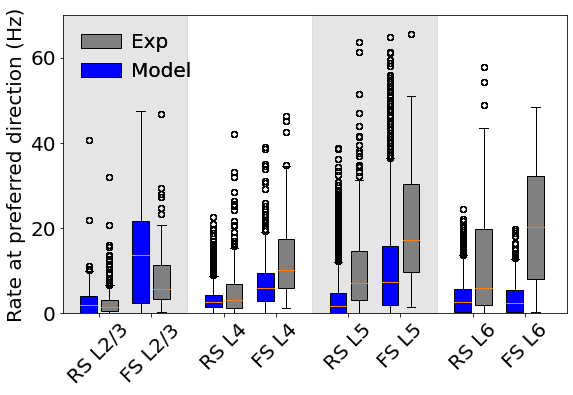

In [43]:
fig, ax = plt.subplots(figsize = (10,6))

fig.subplots_adjust(left = 0.15, right = 0.85, bottom = 0.18, top = 0.87)
layer_nrs = [1]
layer_width_dist = 0
positions = []
for ipop, pop_name in enumerate(rate_at_pref_dir_exp.keys()):
    
    layer_nr = int(pop_name[-1])
        
    if layer_nr > 1:
        if (layer_nr - layer_nrs[-1]) > 0:
            layer_width_dist += 1/2
            
        print(pop_name, layer_nr, layer_nr - layer_nrs[-1], layer_width_dist)
    layer_nrs.append(layer_nr)
    
    if 'RS' in pop_name:
        shift = -1/16
    elif 'FS' in pop_name:
        shift = 1/16
    
    positions.append(ipop/2+layer_width_dist+shift)
    
    
    bp1 = ax.boxplot(rate_at_pref_dir_exp[pop_name], widths = [0.2], positions = [ipop/2+layer_width_dist+1/8+shift], patch_artist = True, \
                         boxprops=dict(facecolor="grey"))
    bp2 = ax.boxplot(pop_rate_pref_dir_sim[pop_name], widths = [0.2], positions = [ipop/2+layer_width_dist-1/8+shift], patch_artist = True, \
                         boxprops=dict(facecolor="blue"))
    
first_legend = plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Exp', 'Model'],  
                          frameon = False, columnspacing = 1, handletextpad = 0.5, ncol = 1, 
                          loc = 2)#bbox_to_anchor = (0.14,0.77))
# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)
    
    
ax.set_xticks(positions)
ax.set_xticklabels(list(pop_rate_pref_dir_sim.keys()), rotation = 45)

ax.set_ylabel('Rate at preferred direction (Hz)')

#ax.set_title('Orientation selectivity index')

ax.fill_between(x = [0, 1.5], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.fill_between(x = [3, 4.5], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.fill_between(x = [16, 21], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.set_ylim([-0.01, 70.01])
ax.set_xlim([0, positions[-1]+.5])

fig_name = 'Rate_at_pref_dir_final_model_exp_RS_and_FS.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

In [44]:
pop_OSI_exp = dict()

In [45]:
for ipop, pop_name in enumerate(pop_names_exp):
    mask_pop = Rates_DF_exp.pop_name.values == pop_name
    OSI = np.array(OSI_DSI_DF_exp[mask_pop].OSI.values, dtype = float)
    
    #mask_nan = np.isnan(OSI)
    #OSI = OSI[~mask_nan]
    
    if pop_name == 'RS L2':
        pop_OSI_exp[pop_name+'/3'] = OSI
    elif pop_name == 'FS L2':
        pop_OSI_exp[pop_name+'/3'] = OSI
    else:
        pop_OSI_exp[pop_name] = OSI
    

RS L2/3 3 2 0.5
FS L2/3 3 0 0.5
RS L4 4 1 1.0
FS L4 4 0 1.0
RS L5 5 1 1.5
FS L5 5 0 1.5
RS L6 6 1 2.0
FS L6 6 0 2.0


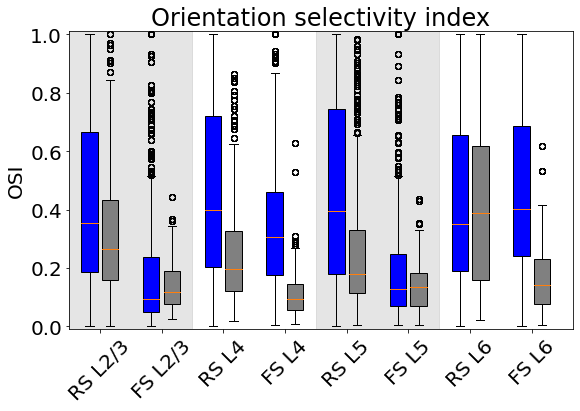

In [49]:
fig, ax = plt.subplots(figsize = (10,6))

fig.subplots_adjust(left = 0.15, right = 0.85, bottom = 0.18, top = 0.87)

layer_nrs = [1]
layer_width_dist = 0
positions = []
for ipop, pop_name in enumerate(pop_OSI_sim.keys()):
    
    layer_nr = int(pop_name[-1])
        
    if layer_nr > 1:
        if (layer_nr - layer_nrs[-1]) > 0:
            layer_width_dist += 1/2
            
        print(pop_name, layer_nr, layer_nr - layer_nrs[-1], layer_width_dist)
    layer_nrs.append(layer_nr)
    
    if 'RS' in pop_name:
        shift = -1/8
    elif 'FS' in pop_name:
        shift = 1/8
    
    positions.append(ipop/2+layer_width_dist+shift)
    
    ax.boxplot(pop_OSI_exp[pop_name], widths = [0.2], positions = [ipop/2+layer_width_dist+1/8+shift], patch_artist = True, \
                         boxprops=dict(facecolor="grey"))
    ax.boxplot(pop_OSI_sim[pop_name], widths = [0.2], positions = [ipop/2+layer_width_dist-1/8+shift], patch_artist = True, \
                         boxprops=dict(facecolor="blue"))
    
#first_legend = plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Exp', 'Model'],  
#                          frameon = False, columnspacing = 1, handletextpad = 0.5, ncol = 1, 
#                          loc = 2)#bbox_to_anchor = (0.14,0.77))
# Add the legend manually to the current Axes.
#plt.gca().add_artist(first_legend)

ax.set_xticks(positions)
ax.set_xticklabels(list(pop_OSI_sim.keys()), rotation = 45)

ax.set_ylabel('OSI')

ax.set_title('Orientation selectivity index')

ax.fill_between(x = [0, 1.5], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.fill_between(x = [3, 4.5], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.fill_between(x = [16, 21], y1 = 70, y2 = -0.01, color = 'grey', alpha = 0.2)
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, positions[-1]+.5])

fig_name = 'OSI_final_model_exp_RS_and_FS.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')